In [150]:
import pandas as pd
import numpy as np
import collections
import os
from statsmodels.stats.contingency_tables import mcnemar
from scipy import stats
from mlxtend.evaluate import mcnemar_table
from matplotlib import pyplot as plt

## functions to calculate metrics

In [ ]:
# Sources:
# https://www.deepset.ai/blog/metrics-to-evaluate-a-question-answering-system
# https://kierszbaumsamuel.medium.com/f1-score-in-nlp-span-based-qa-task-5b115a5e7d41

In [77]:
# Recall measures how many times the correct document was among the retrieved documents
# For a single query, the output is binary: either a document is contained in the selection, or it is not
def correct_retrieved_doc(row):
    source_cols = ["source_1", "source_2", "source_3", "source_4", "source_5"]
    for col in source_cols:
        if row[col] == row["source"]:
            return 1
    return 0

def recall(output):
    return sum(output.apply(correct_retrieved_doc)) / output.shape[0]

In [78]:
# Exact match measures the proportion of documents where the predicted answer is identical to the correct answer
def is_exact_match(row):
    if row["actual_answer"] == row["answer"]:
        return 1
    return 0

def exact_match(output):
    return sum(output.apply(is_exact_match)) / output.shape[0]

In [79]:
# F1 measures the word overlap between the labeled and the predicted answer
# tp: number of tokens* that are shared between the correct answer and the prediction.
# fp: number of tokens that are in the prediction but not in the correct answer.
# fn: number of tokens that are in the correct answer but not in the prediction.
def get_f1(row):
    real_answer = row["actual_answer"].split()
    gen_answer = row["answer"].split()
    common = collections.Counter(real_answer) & collections.Counter(gen_answer)
    num_same = sum(common.values())
    
    if len(real_answer) == 0 or len(gen_answer) == 0:
        return int(real_answer == gen_answer)
    
    if num_same == 0:
        return 0
    
    precision = 1.0 * num_same / len(gen_answer)
    recall = 1.0 * num_same / len(real_answer)
    f1 = (2 * precision * recall) / (precision + recall)
    
    return f1

def overall_f1(output):
    return sum(output.apply(get_f1)) / output.shape[0]

In [131]:
# statistical significance
# mcnemar test for recall and exact match
def stat_sig_mcnemar(baseline, variation):
    contingency_table = mcnemar_table(y_target=np.ones(len(baseline)), y_model1=baseline, y_model2=variation)
    return mcnemar(contingency_table).pvalue

# t test for f1
def stat_sig_t_test(baseline, variation):
    t_stat, p_val = stats.ttest_ind(baseline, variation)
    return p_val

## load results

In [21]:
non_rag_baseline = pd.read_csv("results/results_baseline.csv")
non_rag_baseline.drop(["source_1", "source_2", "source_3", "source_4", "source_5"], axis=1, inplace=True)
rag_baseline = pd.read_csv("results/results_rag_bad_embedding.csv")

In [31]:
variation1 = pd.read_csv("results/results_rag.csv")
variation2 = pd.read_csv("results/results_rag_few_shot_bad_embedding.csv")
variation3 = pd.read_csv("results/results_rag_few_shot.csv")

In [61]:
train_data = pd.read_csv("gemma3_questions_balanced_sample_200.csv")
train_data.drop(["source", "gemma3:12b_answer", "gemma3:12b_question"], axis=1, inplace=True)
train_data.columns = ["source", "question_type", "content_category", "actual_answer"]

In [ ]:
# question, answer, source_1, source_2, source_3, source_4, source_5

In [63]:
# combine results with train data
non_rag_baseline = pd.concat([non_rag_baseline, train_data], axis=1)
rag_baseline = pd.concat([rag_baseline, train_data], axis=1)
variation1 = pd.concat([variation1, train_data], axis=1)
variation2 = pd.concat([variation2, train_data], axis=1)
variation3 = pd.concat([variation3, train_data], axis=1)

## calculate metrics

In [87]:
# get metrics for baseline models
non_rag_baseline["em"] = non_rag_baseline.apply(is_exact_match, axis=1)
non_rag_baseline["f1"] = non_rag_baseline.apply(get_f1, axis=1)

rag_baseline["recall"] = rag_baseline.apply(correct_retrieved_doc, axis=1)
rag_baseline["em"] = rag_baseline.apply(is_exact_match, axis=1)
rag_baseline["f1"] = rag_baseline.apply(get_f1, axis=1)

In [118]:
print("non rag metrics")
print(f'em: {non_rag_baseline["em"].mean()}')
print(f'f1: {non_rag_baseline["f1"].mean()}')
print("\n")

print("rag baseline metrics")
print(f'recall: {rag_baseline["recall"].mean()}')
print(f'em: {rag_baseline["em"].mean()}')
print(f'f1: {rag_baseline["f1"].mean()}')

non rag metrics
em: 0.0
f1: 0.05685775923885378


rag baseline metrics
recall: 0.41
em: 0.0
f1: 0.11131313260860196


In [132]:
# statistical test for em, f1 for non rag vs rag baseline
print("non rag vs rag baseline")
print("em:", stat_sig_mcnemar(non_rag_baseline["em"], rag_baseline["em"]))
print("f1:", stat_sig_t_test(non_rag_baseline["f1"], rag_baseline["f1"]))

non rag vs rag baseline
em: 1.0
f1: 2.5059085750187265e-06


In [133]:
variations = [variation1, variation2, variation3]
var_names = ["variation 1", "variation 2", "variation 3"]
metric_cols = ["recall", "em", "f1"]

for i in range(len(variations)):
    var = variations[i]
    # add columns with metrics
    var["recall"] = var.apply(correct_retrieved_doc, axis=1)
    var["em"] = var.apply(is_exact_match, axis=1)
    var["f1"] = var.apply(get_f1, axis=1)
    
    # print metrics
    print(f'{var_names[i]} metrics')
    print("recall:", var["recall"].mean())
    print("em:", var["em"].mean())
    print("f1:", var["f1"].mean())
    print("\n")
    
    # significance tests against rag baseline
    print(f'rag baseline vs {var_names[i]}')
    print("recall:", stat_sig_mcnemar(rag_baseline["recall"], var["recall"]))
    print("em:", stat_sig_mcnemar(rag_baseline["em"], var["em"]))
    print("f1:", stat_sig_t_test(rag_baseline["f1"], var["f1"]))
    print("\n")

variation 1 metrics
recall: 0.545
em: 0.0
f1: 0.12425176189147388


rag baseline vs variation 1
recall: 4.1934157934520044e-05
em: 1.0
f1: 0.3479308473811954


variation 2 metrics
recall: 0.41
em: 0.0
f1: 0.11131313260860196


rag baseline vs variation 2
recall: 1.0
em: 1.0
f1: 1.0


variation 3 metrics
recall: 0.545
em: 0.0
f1: 0.13067888956981413


rag baseline vs variation 3
recall: 4.1934157934520044e-05
em: 1.0
f1: 0.19635264626893023




## analysis

In [138]:
non_rag_df = non_rag_baseline[["question", "question_type", "content_category", "actual_answer", "answer"]]
df = pd.concat([non_rag_df, rag_baseline["answer"], variation1["answer"], variation2["answer"], 
                variation3["answer"]], axis=1)
df.columns = ["question", "question_type", "content_category", "actual_answer", "non_rag_answer", 
              "rag_baseline_answer", "var1_answer", "var2_answer", "var3_answer"]

In [139]:
df.head()

,question,question_type,content_category,actual_answer,non_rag_answer,rag_baseline_answer,var1_answer,var2_answer,var3_answer
0,What is the Planning Commission charged with g...,Specific information questions,General Info and History of Pittsburgh/CMU,Land use and development.,The Planning Commission is charged with guidi...,\n The Planning Commission is charg...,\n The Planning Commission is charg...,\n The Planning Commission is charg...,\n The Planning Commission is charg...
1,What types of services are provided by the Dep...,Specific information questions,General Info and History of Pittsburgh/CMU,"Office of Equal Protection, Commission on Huma...",\n\nThe Department of Law provides various leg...,\n\n The Department of Law provides...,\n\nThe Department of Law provides various leg...,\n\n The Department of Law provides...,\n\n The Department of Law provides...
2,What phone number should be included on a pet'...,Specific information questions,General Info and History of Pittsburgh/CMU,Your phone number.,The phone number that should be included on a...,The phone number that should be included on a...,\n The phone number that should be ...,The phone number that should be included on a...,The phone number that should be included on a...
3,"According to the provided text, how may employ...",Specific information questions,General Info and History of Pittsburgh/CMU,Use each employee’s working hours within Pitts...,\n\nEmployers can compute their payroll expens...,\n\n Employers whose employees perf...,\n\n Employers whose employees perf...,\n\n Employers whose employees perf...,\n\n Employers whose employees perf...
4,When was the Pittsburgh Soul Food Festival est...,Specific information questions,General Info and History of Pittsburgh/CMU,2019,The Pittsburgh Soul Food Festival was establi...,2019.,The Pittsburgh Soul Food Festival was establi...,2019.,2019. \n\n The Pittsburgh Soul Food...


In [145]:
df.to_csv("concat_answers_results.csv", index=False)

In [ ]:
# concision

In [ ]:
def get_answer_length(row):
    

In [148]:
answer_lengths = [ ]
answer_cols = ["actual_answer", "non_rag_answer", "rag_baseline_answer", "var1_answer", "var2_answer", 
               "var3_answer"]

for col in answer_cols:
    answer_lengths.append(df[col].str.split().str.len().to_list())

In [156]:
for i in range(len(answer_lengths)):
    print(answer_cols[i])
    print(np.median(answer_lengths[i]))

actual_answer
7.0
non_rag_answer
50.5
rag_baseline_answer
44.0
var1_answer
44.5
var2_answer
44.0
var3_answer
43.0


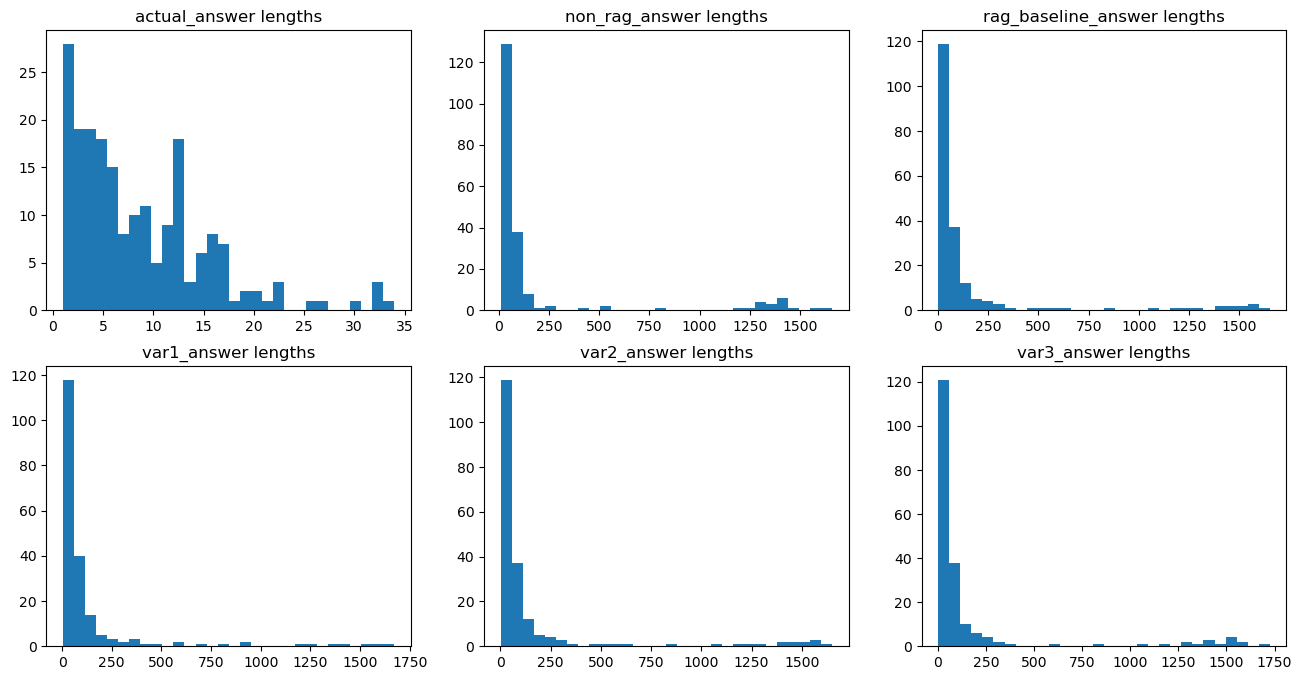

In [181]:
figure, axis = plt.subplots(2, 3, figsize=(16,8))
indices = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]

for a in range(len(answer_cols)):
    i, j = tuple(indices[a])
    axis[i, j].hist(answer_lengths[a], bins=30)
    axis[i, j].set_title(answer_cols[a] + " lengths")

plt.show()

In [ ]:
# performance across question types

In [201]:
def get_cat_vals(models, metric, col_name, categories):
    result = [ ]
    for c in categories:
        row = [ ]
        for m in models:
            row.append(m[m[col_name] == c][metric].mean())
        result.append(row)
    return result

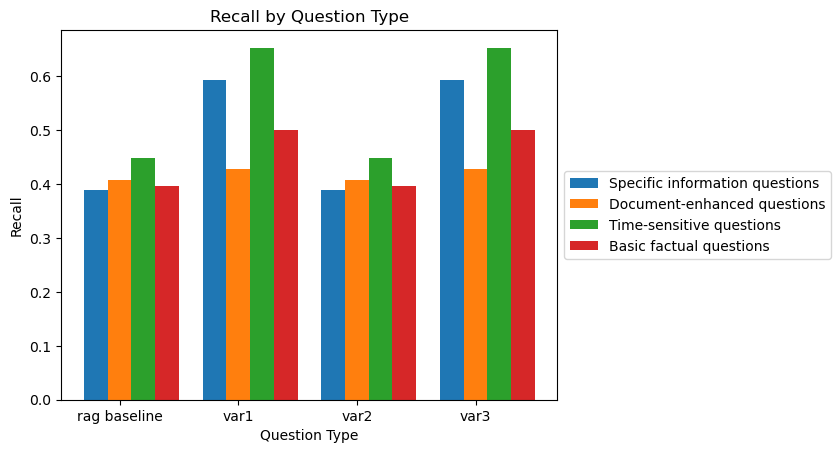

In [206]:
models = [rag_baseline, variation1, variation2, variation3]
model_names = ["rag baseline", "variation 1", "variation 2", "variation 3"]
q_types = df["question_type"].unique()

vals = get_cat_vals(models, "recall", "question_type", q_types)

N = 4
ind = np.arange(4)  
width = 0.2
  
bar1 = plt.bar(ind, vals[0], width) 
bar2 = plt.bar(ind+width, vals[1], width) 
bar3 = plt.bar(ind+width*2, vals[2], width) 
bar4 = plt.bar(ind+width*3, vals[3], width) 
  
plt.xlabel("Question Type") 
plt.ylabel('Recall') 
plt.title("Recall by Question Type") 

plt.xticks(ind+width, ["rag baseline", "var1", "var2", "var3"]) 
plt.legend((bar1, bar2, bar3, bar4), q_types, loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show() 

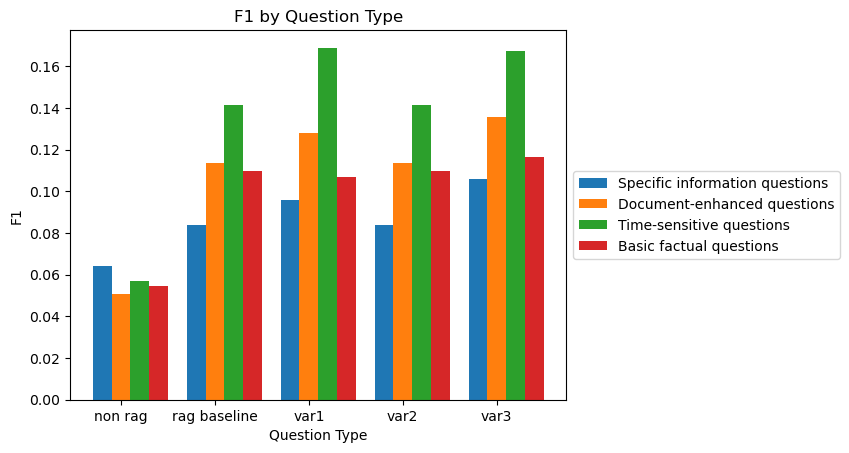

In [211]:
models = [non_rag_baseline, rag_baseline, variation1, variation2, variation3]
model_names = ["rag baseline", "variation 1", "variation 2", "variation 3"]
q_types = df["question_type"].unique()

vals = get_cat_vals(models, "f1", "question_type", q_types)

N = 5
ind = np.arange(5)  
width = 0.2
  
bar1 = plt.bar(ind, vals[0], width) 
bar2 = plt.bar(ind+width, vals[1], width) 
bar3 = plt.bar(ind+width*2, vals[2], width) 
bar4 = plt.bar(ind+width*3, vals[3], width) 
  
plt.xlabel("Question Type") 
plt.ylabel('F1') 
plt.title("F1 by Question Type") 

plt.xticks(ind+width, ["non rag", "rag baseline", "var1", "var2", "var3"]) 
plt.legend((bar1, bar2, bar3, bar4), q_types, loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show() 

In [ ]:
# performance across content categories

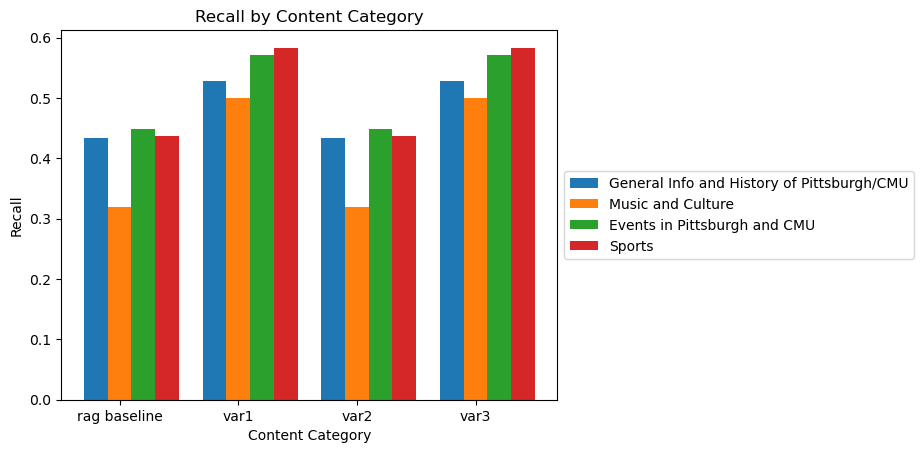

In [215]:
models = [rag_baseline, variation1, variation2, variation3]
model_names = ["rag baseline", "variation 1", "variation 2", "variation 3"]
cats = df["content_category"].unique()

vals = get_cat_vals(models, "recall", "content_category", cats)

N = 4
ind = np.arange(4)  
width = 0.2
  
bar1 = plt.bar(ind, vals[0], width) 
bar2 = plt.bar(ind+width, vals[1], width) 
bar3 = plt.bar(ind+width*2, vals[2], width) 
bar4 = plt.bar(ind+width*3, vals[3], width) 
  
plt.xlabel("Content Category") 
plt.ylabel('Recall') 
plt.title("Recall by Content Category") 

plt.xticks(ind+width, ["rag baseline", "var1", "var2", "var3"]) 
plt.legend((bar1, bar2, bar3, bar4), cats, loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show() 

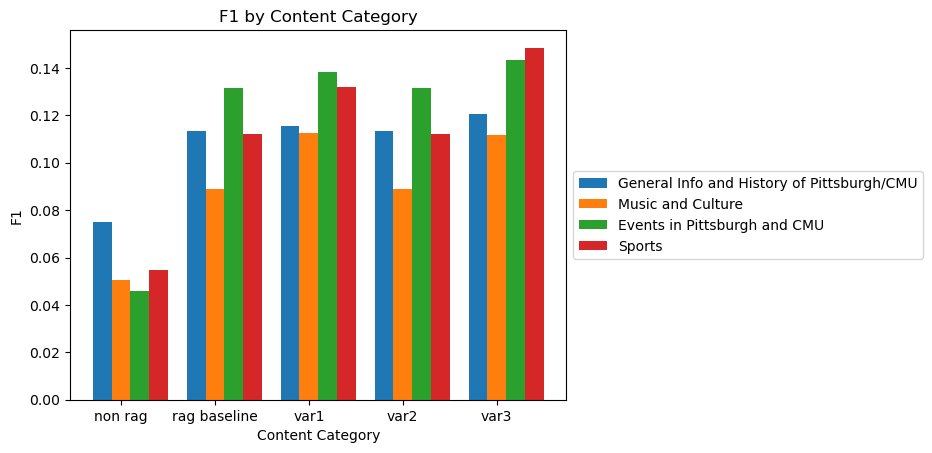

In [216]:
models = [non_rag_baseline, rag_baseline, variation1, variation2, variation3]
model_names = ["rag baseline", "variation 1", "variation 2", "variation 3"]
cats = df["content_category"].unique()

vals = get_cat_vals(models, "f1", "content_category", cats)

N = 5
ind = np.arange(5)  
width = 0.2
  
bar1 = plt.bar(ind, vals[0], width) 
bar2 = plt.bar(ind+width, vals[1], width) 
bar3 = plt.bar(ind+width*2, vals[2], width) 
bar4 = plt.bar(ind+width*3, vals[3], width) 
  
plt.xlabel("Content Category") 
plt.ylabel('F1') 
plt.title("F1 by Content Category") 

plt.xticks(ind+width, ["non rag", "rag baseline", "var1", "var2", "var3"]) 
plt.legend((bar1, bar2, bar3, bar4), cats, loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show() 

In [169]:
models = [rag_baseline, variation1, variation2, variation3]
model_names = ["rag baseline", "variation 1", "variation 2", "variation 3"]

for i in range(len(models)):
    mod = models[i]
    mod_name = model_names[i]
    print(mod_name)
    for q in q_types:
        print(q, ":", round(mod[mod["question_type"] == q]["recall"].mean(), 4))
    print("\n")

rag baseline
Specific information questions : 0.3889
Document-enhanced questions : 0.4082
Time-sensitive questions : 0.449
Basic factual questions : 0.3958


variation 1
Specific information questions : 0.5926
Document-enhanced questions : 0.4286
Time-sensitive questions : 0.6531
Basic factual questions : 0.5


variation 2
Specific information questions : 0.3889
Document-enhanced questions : 0.4082
Time-sensitive questions : 0.449
Basic factual questions : 0.3958


variation 3
Specific information questions : 0.5926
Document-enhanced questions : 0.4286
Time-sensitive questions : 0.6531
Basic factual questions : 0.5




In [170]:
models = [non_rag_baseline, rag_baseline, variation1, variation2, variation3]
model_names = ["non rag baseline", "rag baseline", "variation 1", "variation 2", "variation 3"]
for i in range(len(models)):
    mod = models[i]
    mod_name = model_names[i]
    print(mod_name)
    for q in q_types:
        print(q, ":", round(mod[mod["question_type"] == q]["f1"].mean(), 4))
    print("\n")

non rag baseline
Specific information questions : 0.0642
Document-enhanced questions : 0.0509
Time-sensitive questions : 0.0568
Basic factual questions : 0.0548


rag baseline
Specific information questions : 0.0836
Document-enhanced questions : 0.1133
Time-sensitive questions : 0.1413
Basic factual questions : 0.1099


variation 1
Specific information questions : 0.0956
Document-enhanced questions : 0.1281
Time-sensitive questions : 0.1688
Basic factual questions : 0.1071


variation 2
Specific information questions : 0.0836
Document-enhanced questions : 0.1133
Time-sensitive questions : 0.1413
Basic factual questions : 0.1099


variation 3
Specific information questions : 0.106
Document-enhanced questions : 0.1354
Time-sensitive questions : 0.1672
Basic factual questions : 0.1164




In [ ]:
# performance across content categories

In [172]:
cats = df["content_category"].unique()

In [174]:
models = [rag_baseline, variation1, variation2, variation3]
model_names = ["rag baseline", "variation 1", "variation 2", "variation 3"]
for i in range(len(models)):
    mod = models[i]
    mod_name = model_names[i]
    print(mod_name)
    for c in cats:
        print(c, ":", round(mod[mod["content_category"] == c]["recall"].mean(), 4))
    print("\n")

rag baseline
General Info and History of Pittsburgh/CMU : 0.434
Music and Culture : 0.32
Events in Pittsburgh and CMU : 0.449
Sports : 0.4375


variation 1
General Info and History of Pittsburgh/CMU : 0.5283
Music and Culture : 0.5
Events in Pittsburgh and CMU : 0.5714
Sports : 0.5833


variation 2
General Info and History of Pittsburgh/CMU : 0.434
Music and Culture : 0.32
Events in Pittsburgh and CMU : 0.449
Sports : 0.4375


variation 3
General Info and History of Pittsburgh/CMU : 0.5283
Music and Culture : 0.5
Events in Pittsburgh and CMU : 0.5714
Sports : 0.5833




In [176]:
models = [non_rag_baseline, rag_baseline, variation1, variation2, variation3]
model_names = ["non rag baseline", "rag baseline", "variation 1", "variation 2", "variation 3"]
for i in range(len(models)):
    mod = models[i]
    mod_name = model_names[i]
    print(mod_name)
    for c in cats:
        print(c, ":", round(mod[mod["content_category"] == c]["f1"].mean(), 4))
    print("\n")

non rag baseline
General Info and History of Pittsburgh/CMU : 0.0748
Music and Culture : 0.0506
Events in Pittsburgh and CMU : 0.046
Sports : 0.0546


rag baseline
General Info and History of Pittsburgh/CMU : 0.1132
Music and Culture : 0.0889
Events in Pittsburgh and CMU : 0.1314
Sports : 0.112


variation 1
General Info and History of Pittsburgh/CMU : 0.1156
Music and Culture : 0.1126
Events in Pittsburgh and CMU : 0.1381
Sports : 0.1318


variation 2
General Info and History of Pittsburgh/CMU : 0.1132
Music and Culture : 0.0889
Events in Pittsburgh and CMU : 0.1314
Sports : 0.112


variation 3
General Info and History of Pittsburgh/CMU : 0.1207
Music and Culture : 0.1117
Events in Pittsburgh and CMU : 0.1434
Sports : 0.1485




In [224]:
df[df["question_type"] == "Document-enhanced questions"]["question"]

24     What is included in Mitchell’s Fish Market Res...
25     What categories of activities are listed as op...
26     What is the name of the new permanent exhibit ...
27     What is the name of the event that brings loca...
28     What unique feature does the Federal Galley of...
29     Who is the artist for the 'Fabrics of the Comm...
30     What special event takes place on select Tuesd...
31     What is the name of the attraction mentioned i...
32     What categories of travel are specifically hig...
33     What is the phone number for The Church Brew W...
34     When does the 'Merry Little Christmas' pop-up ...
35     What criteria are VisitPITTSBURGH board member...
84     What are the opening and closing dates for the...
85     What does the University Libraries’ exhibit of...
86     What is the phone number for The Original Pitt...
87     What dates will the 42nd annual Three Rivers F...
88     What does the University Libraries’ exhibit of...
89     What is the purpose of t

In [227]:
!citepy nltk

zsh:1: command not found: citepy
